In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import xarray as xr

from implicit_filter import LatLonFilter

# Regular latitude-longitude grid example
---

When data is already interpolated to "normal" grid, it's alost always a lat-lon grid.
In this case implicit filter can be used.
This notebook shows how to use LatLonFilter for such cases

In [2]:
ds = xr.open_dataset("../t_scaling.nc")
ds

<xarray.Dataset>
Dimensions:    (lon: 5136, lat: 2560)
Coordinates:
  * lon        (lon) float64 0.0 0.07009 0.1402 0.2103 ... 359.8 359.9 359.9
  * lat        (lat) float64 -89.96 -89.89 -89.82 -89.75 ... 89.82 89.89 89.96
Data variables:
    t_scaling  (lat, lon) float32 ...

### Load entire array or relevant part

In [3]:
global_lat = ds.lat.values
global_lon = ds.lon.values
global_tt = ds["t_scaling"].values

europe_lat = ds.lat[1750:2300].values
europe_lon = np.concatenate((ds.lon[-150:].values - 360., ds.lon[:410].values), axis=0)
europe_tt = np.concatenate((ds["t_scaling"][1750:2300, -150:].values, ds["t_scaling"][1750:2300, :410].values), axis=1)

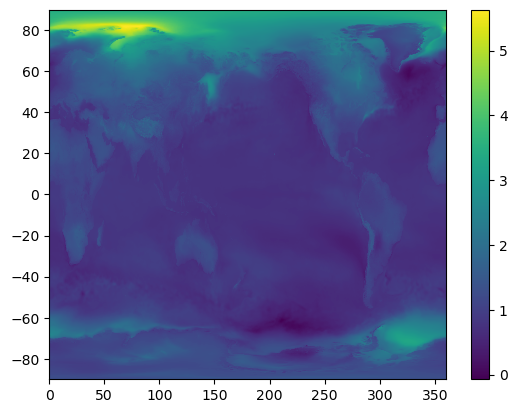

In [4]:
plt.pcolormesh(global_lon, global_lat, global_tt, shading="auto")
plt.colorbar()

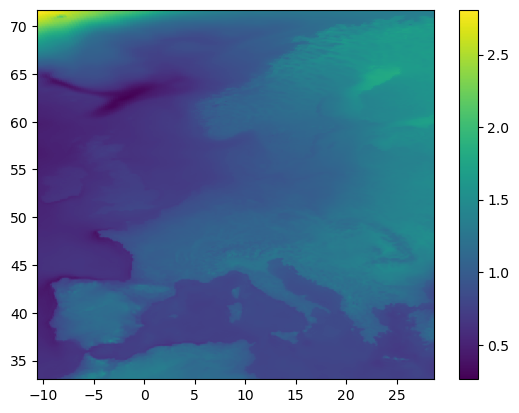

In [5]:
plt.pcolormesh(europe_lon, europe_lat, europe_tt, shading="auto")
plt.colorbar()

# Prepare the filter
---

Prepare filter object for each use case.
When the mesh is non-cartesian it is important to remove from data areas close to the poles.
For those areas, metric terms are close to 0, resulting in filter not converging.

###  For global data let's assume the mesh is flat

The local parameters marks if the mesh wraps around earth or is just a part of it

In [6]:
global_filter = LatLonFilter()
global_filter.prepare(global_lon, global_lat, cartesian=True, local=False)

### For local filter let's take into account effects of Earth's shape

In [7]:
europe_filter = LatLonFilter()
europe_filter.prepare(europe_lon, europe_lat, cartesian=False, local=True)

### Just like for all other filters, auxiliary arrays can be saved and used later

In [8]:
europe_filter.save_to_file("../latlon_cash")
europe_filter = LatLonFilter.load_from_file("../latlon_cash.npz")

# Filtering

---

### Apply filter

In [13]:
europe_ttu = europe_filter.compute(n=1, k=2. * math.pi / 100, data=europe_tt)
global_ttu = global_filter.compute(n=1, k=2. * math.pi / 100, data=global_tt)

### Visualise results

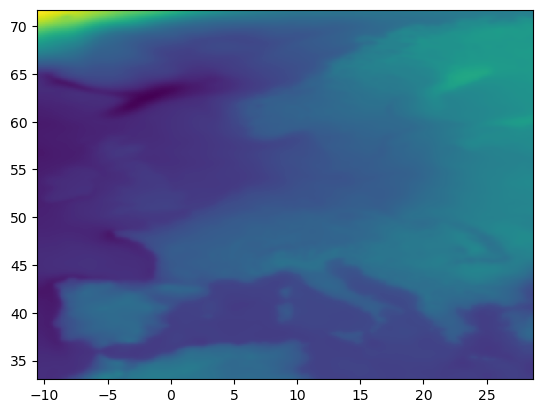

In [14]:
plt.pcolormesh(europe_lon, europe_lat, europe_ttu, shading='nearest')

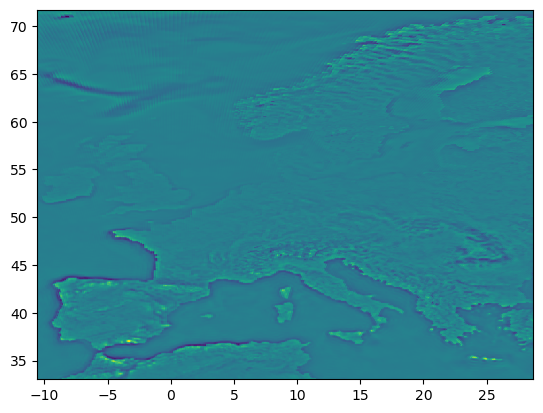

In [15]:
plt.pcolormesh(europe_lon, europe_lat, europe_tt - europe_ttu, shading='nearest')

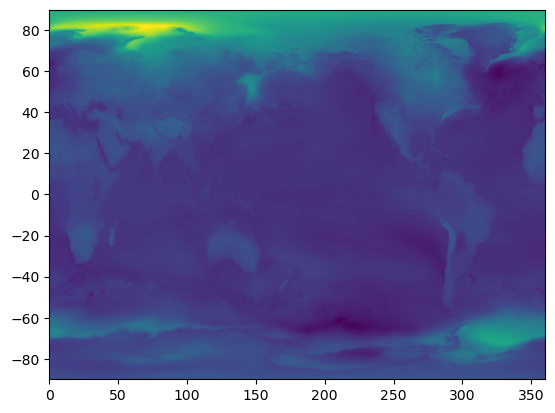

In [16]:
plt.pcolormesh(global_lon, global_lat, global_ttu, shading='nearest')